# Анализ временного ряда среднемесячной заработной платы в России

python3

### 0. Импорт библиотек и считывание данных

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
wages = pd.read_csv('WAG_C_M.csv', sep=';', names=['month', 'data'],
                    index_col=['month'], header=0, parse_dates=['month'], dayfirst=True)

In [3]:
wages.head()

,data
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


### 1. Визуальный анализ ряда

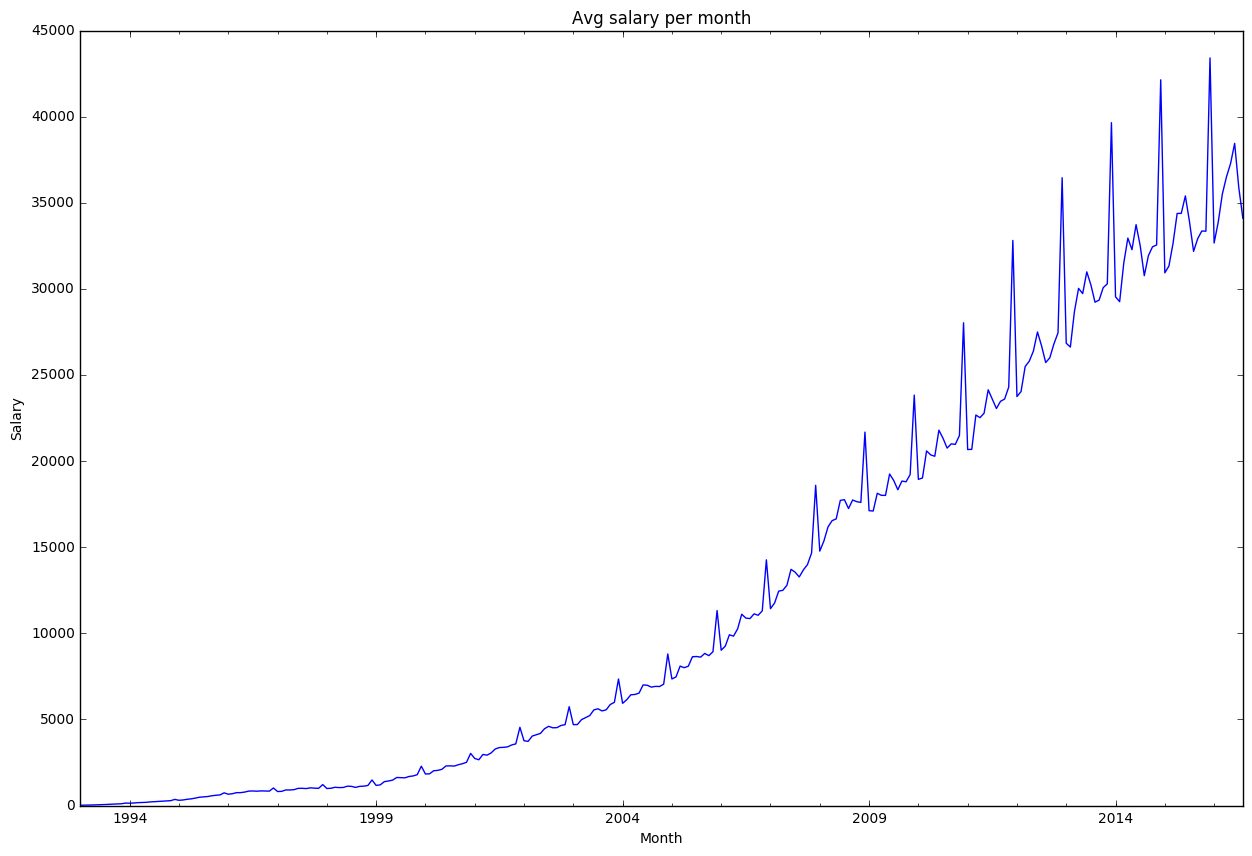

In [4]:
plt.figure(figsize(15, 10))
wages.data.plot()
plt.title('Avg salary per month')
plt.xlabel('Month')
plt.ylabel('Salary')
pylab.show()

Ярко выражен тренд, сезонность с периодом 12.
Дисперсия возрастает со временем.

Критерий Дики-Фуллера: p=0.991850


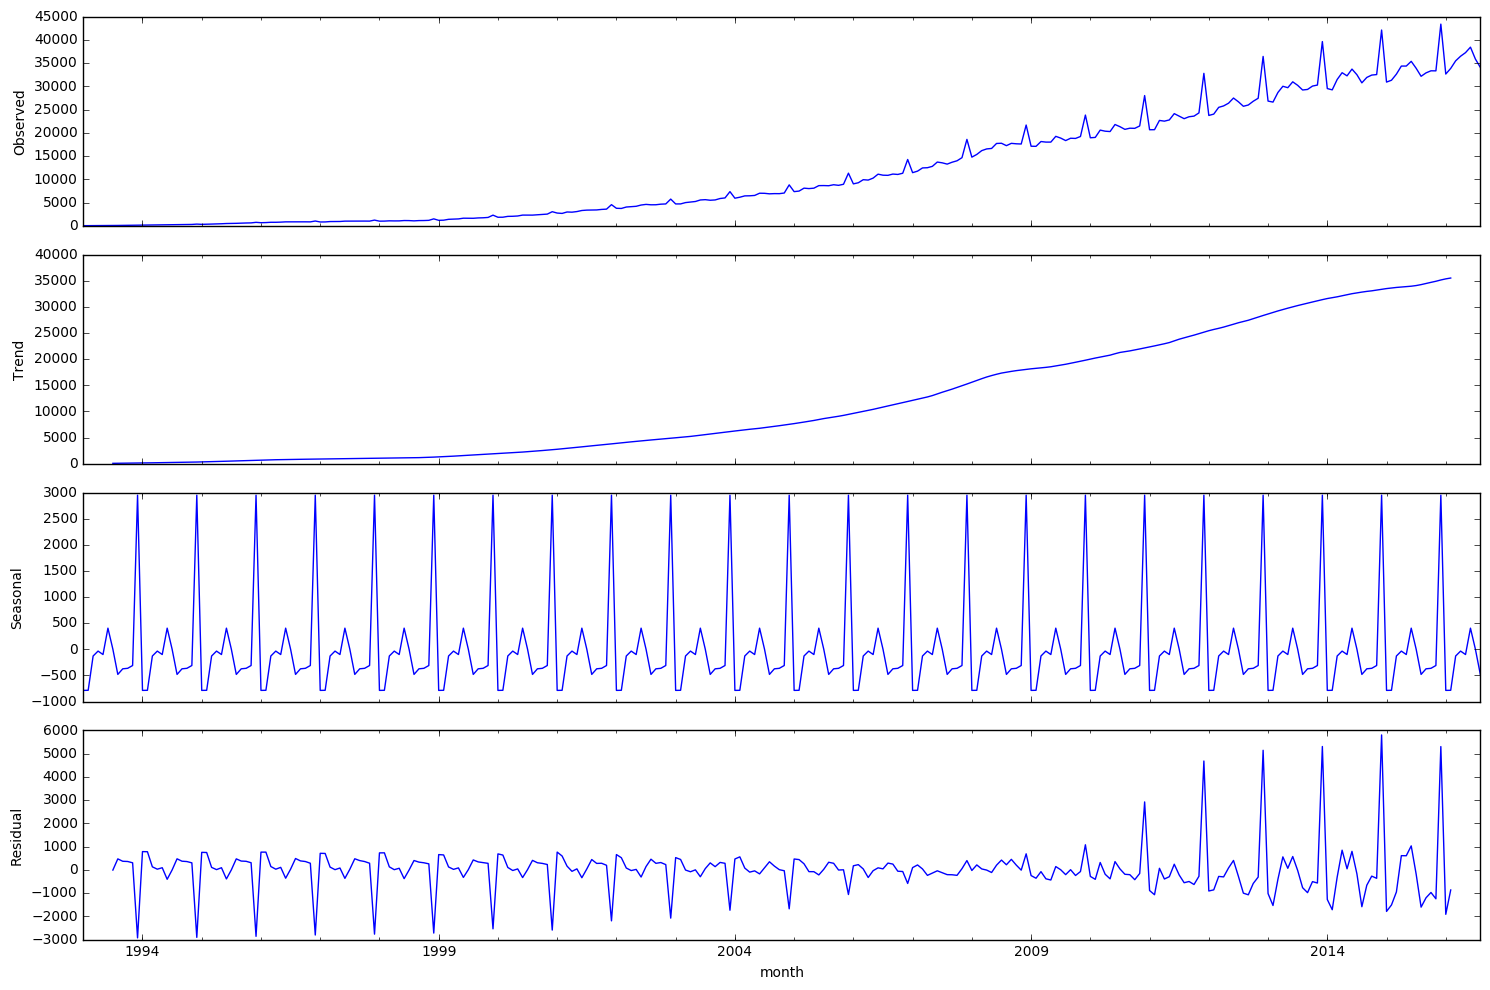

In [5]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages.data).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.data)[1])

### 2. Стабилизация дисперсии (при необходимости)

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


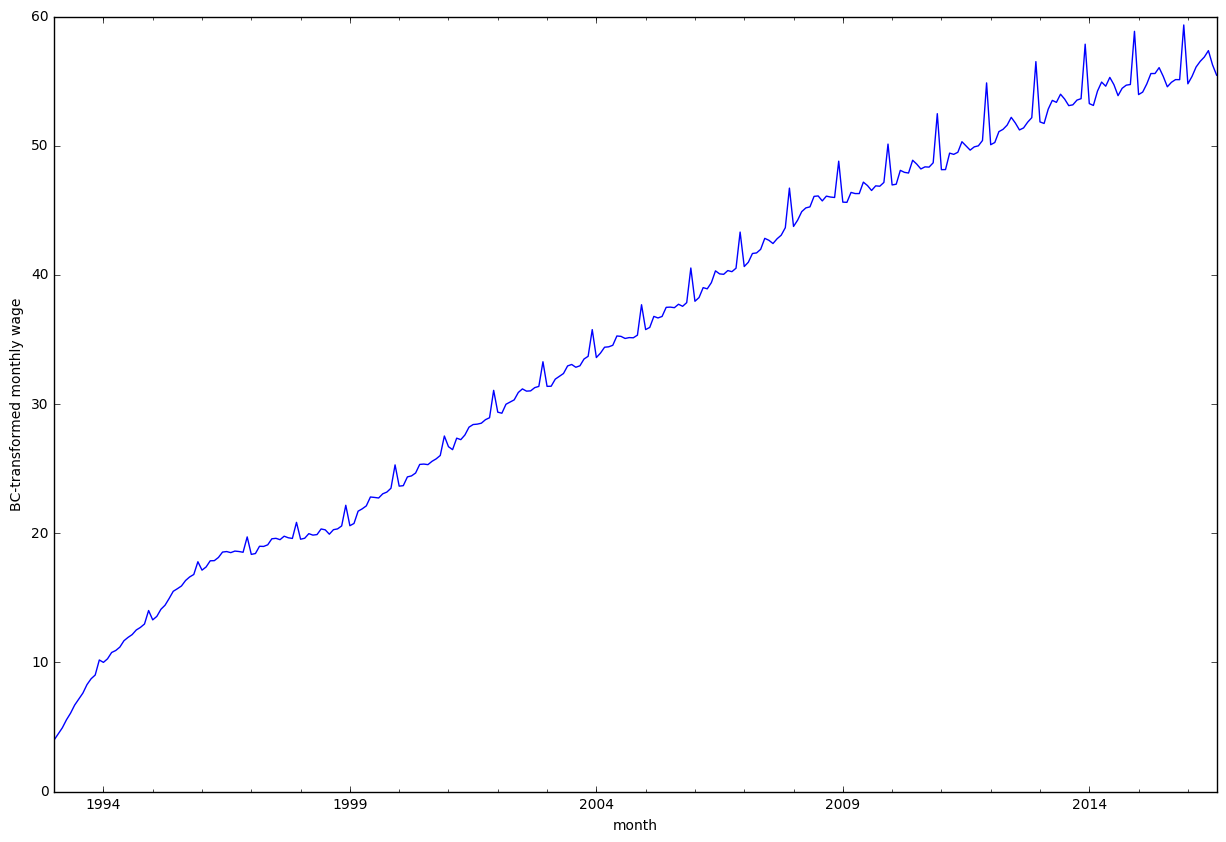

In [6]:
wages['box'], lmbda = stats.boxcox(wages.data)
plt.figure(figsize(15,10))
wages.box.plot()
plt.ylabel('BC-transformed monthly wage')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.box)[1])

Ряд явно нестационарный, кроме того, дисперсия очевидно не стабилизировалась.
Будем рассматривать только поздние данные повышенной репрезентативности.

In [7]:
wages = wages['2004-1':]

Оптимальный параметр преобразования Бокса-Кокса: 0.609542
Критерий Дики-Фуллера: p=0.286993


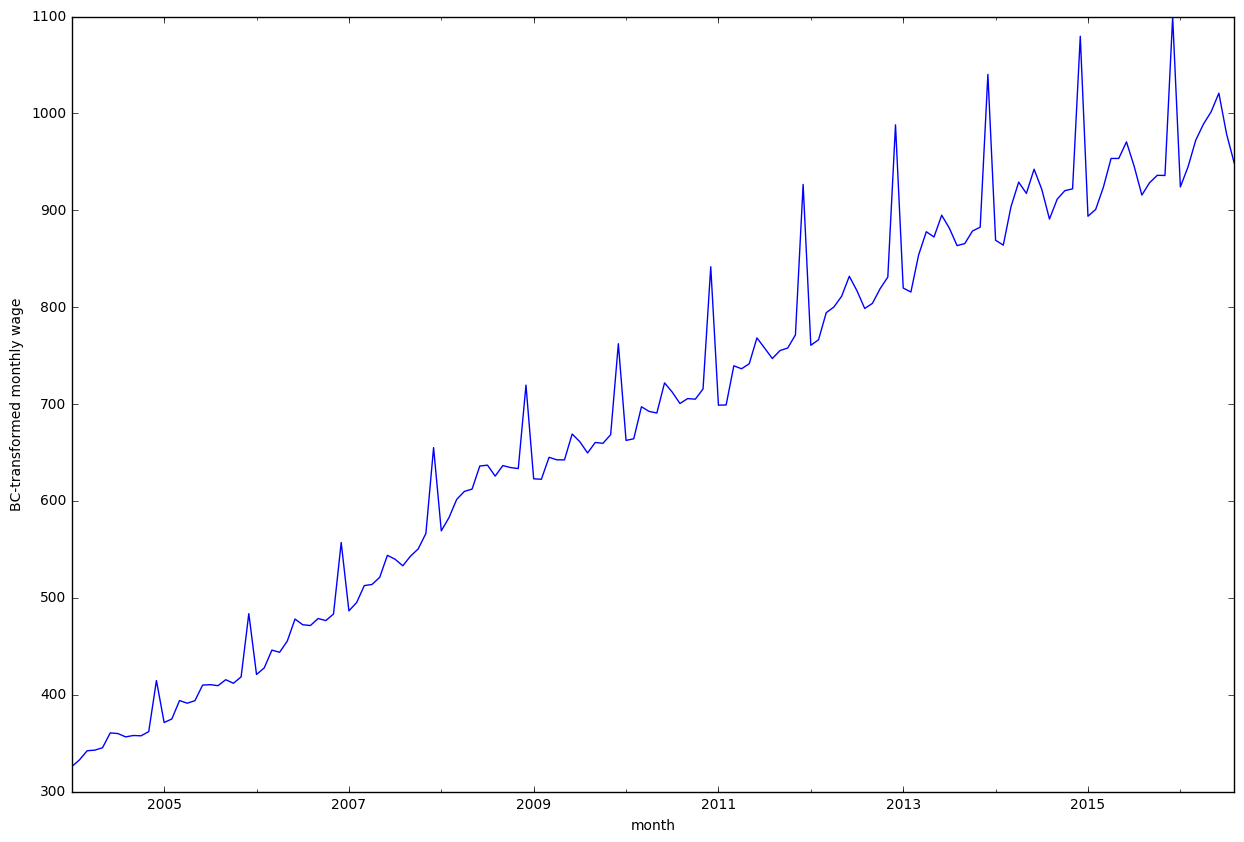

In [8]:
wages['box'], lmbda = stats.boxcox(wages.data)
plt.figure(figsize(15,10))
wages.box.plot()
plt.ylabel('BC-transformed monthly wage')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.box)[1])

Уже неплохо.

### 3. Выбор порядка дифференцирования

Очевидная сезонность с периодом 12, поэтому в первую очередь убираем ее.

Критерий Дики-Фуллера: p=0.202803


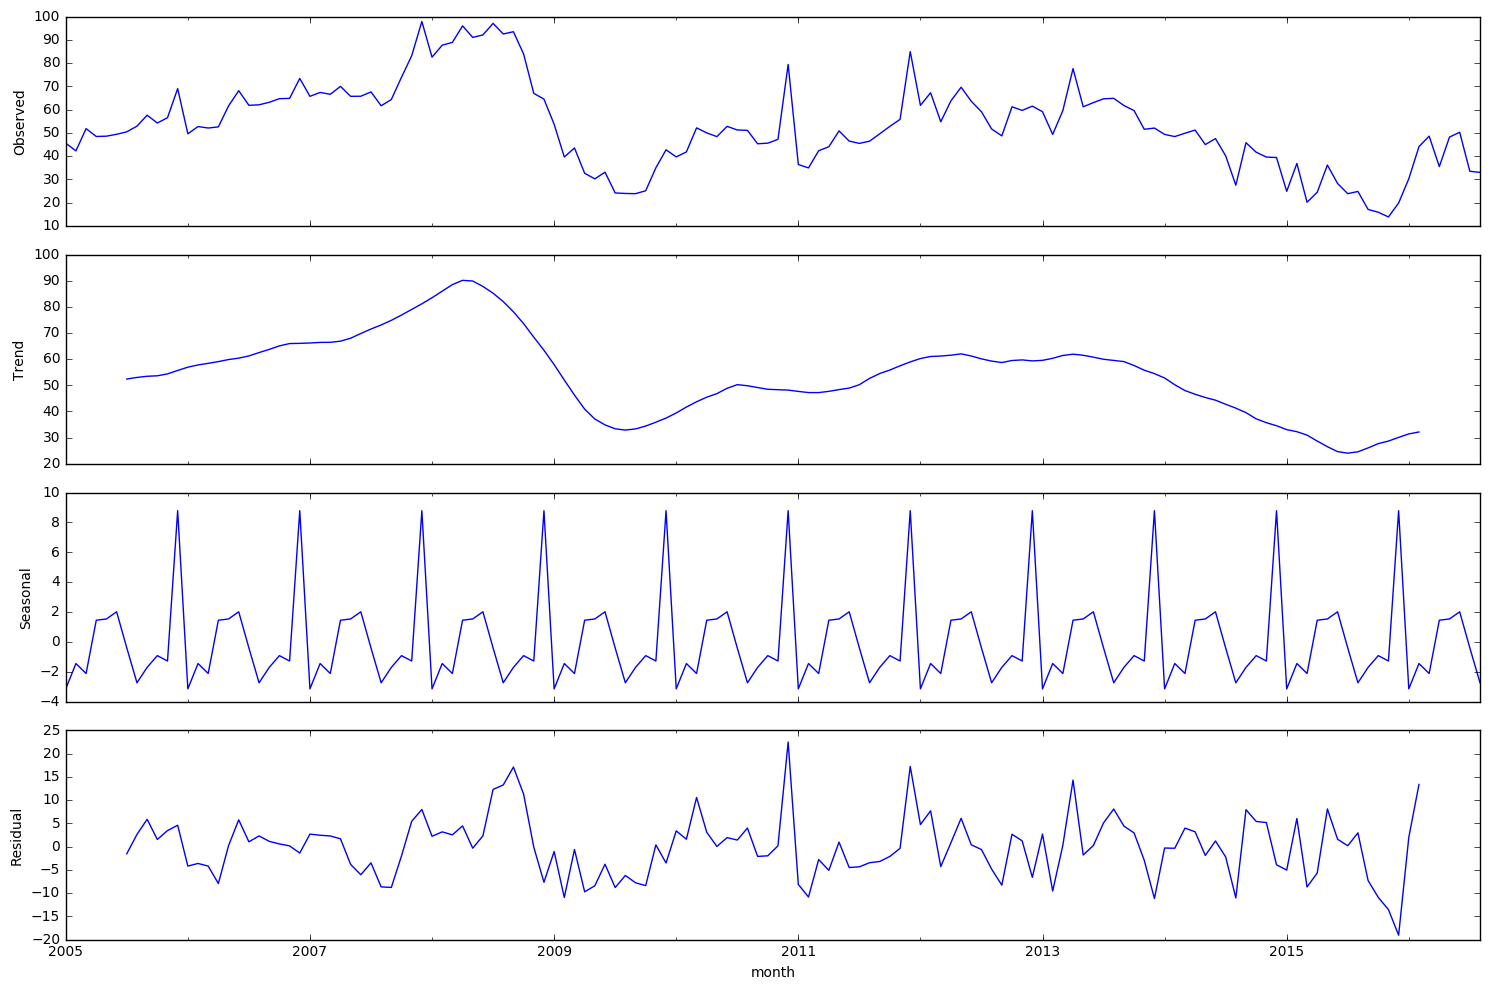

In [9]:
wages['diff12'] = wages.box - wages.box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages.diff12[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.diff12[12:])[1])

Критерий Дики-Фуллера все еще существенный -> нестационарность.

Добавим обычное дифференцирование.

Критерий Дики-Фуллера: p=0.000000


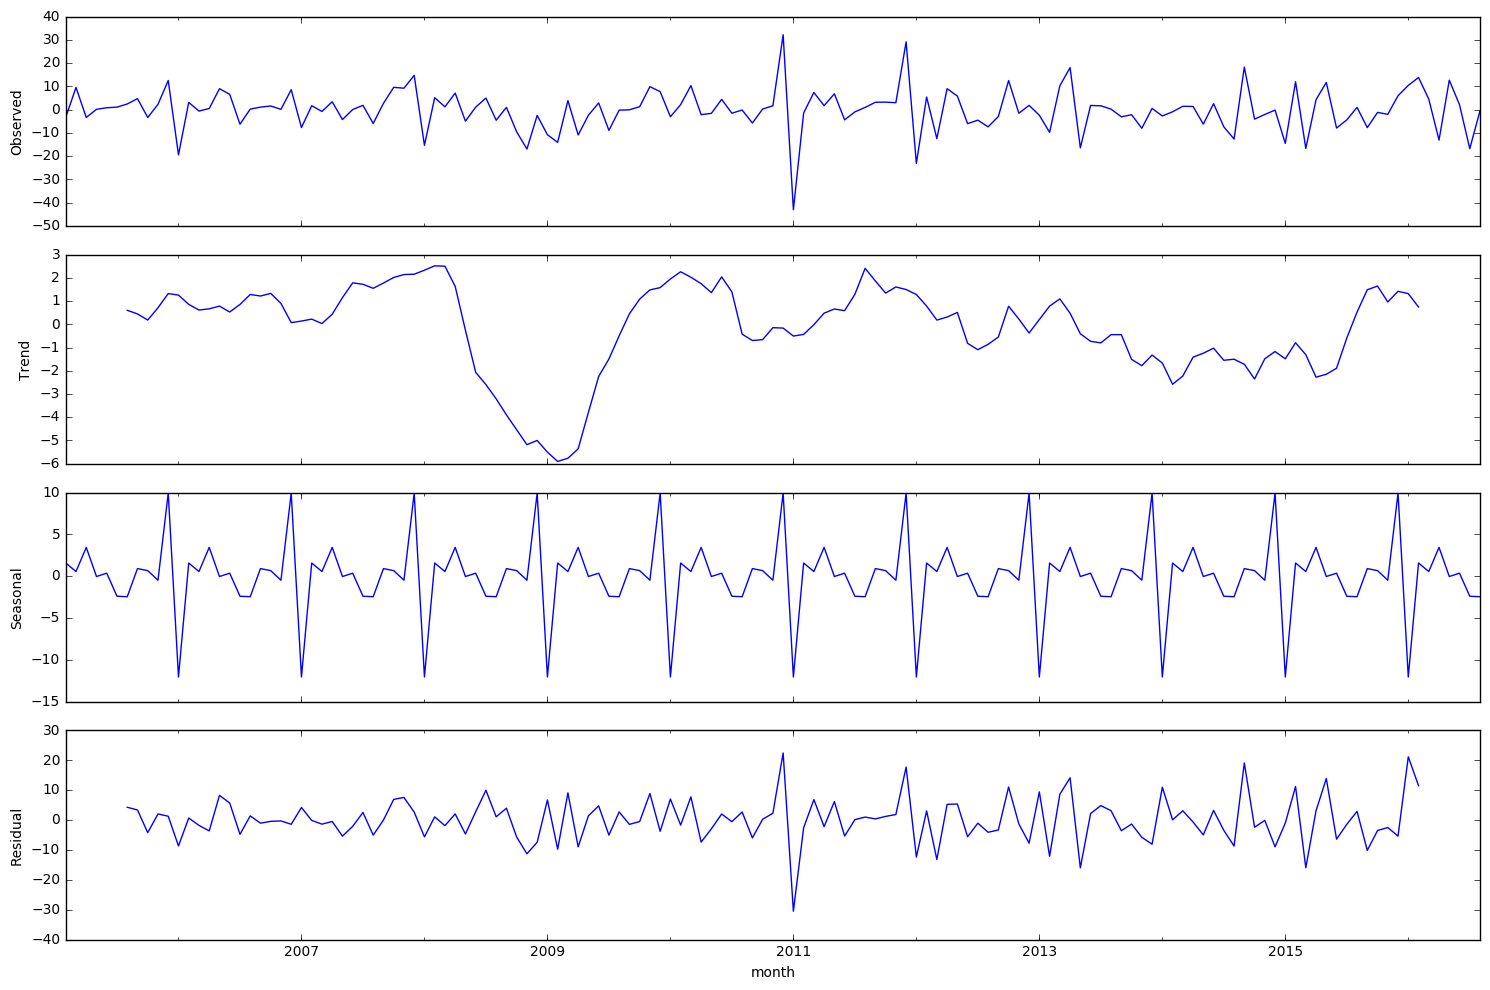

In [10]:
wages['diff13'] = wages.diff12 - wages.diff12.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages.diff13[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.diff13[13:])[1])

Критерий Дики-Фуллера уверенно отвергает гипотезу о нестационарности.
Однако, в тренде присутствуют провалы, наиболее заметный из которых соответствует экономическому кризису 2008 года, поэтому стационарности на самом деле нет.

### 4. Выбор начальных приближений для p,q,P,Q

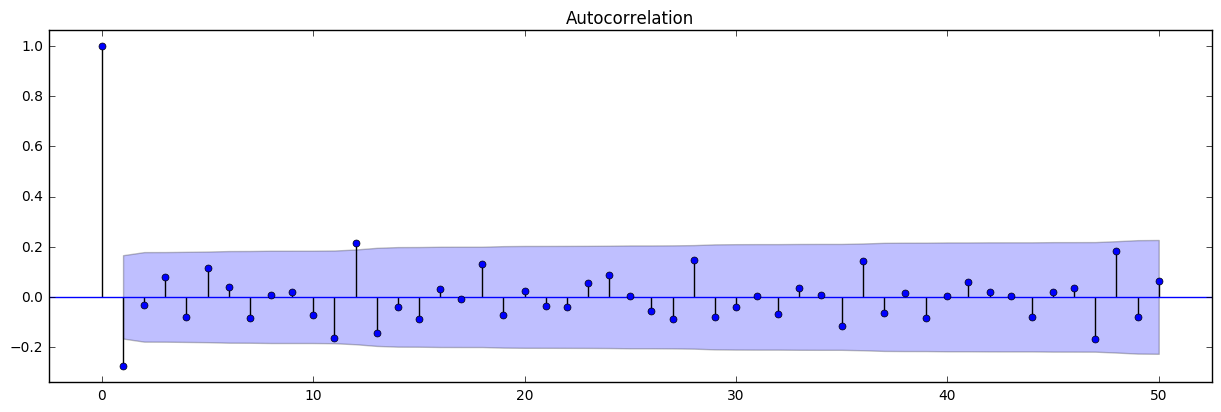

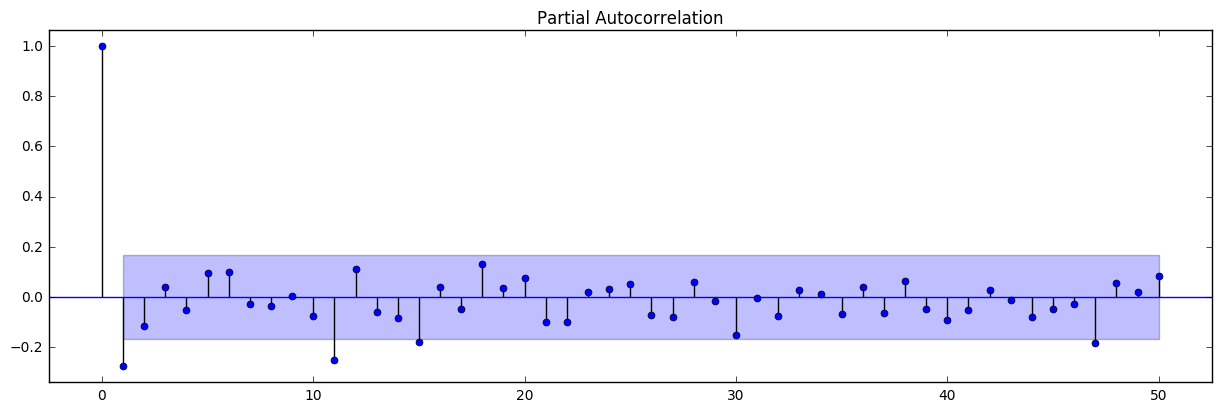

In [11]:
plt.figure(figsize(15,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wages.diff13[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wages.diff13[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

Имеется сезонный лаг 12 со значимой автокорреляцией, поэтому выбираем Q = 12/S = 1.
Имеется несезонный лаг 1 со значимой автокорреляцией, поэтому выбираем q = 1.

Сезонный лаг со значимой частичной автокорреляцией отсутствует, поэтому выбираем на всякий случай P = 1
(справочно: улучшает модель на 4 пункта по сравнению с лучшей моделью при P=0).
Имееются несезонные лаги 1, 11, 15, 47 со значимой автокорреляцией, выбираем не слишком большой p = 11.

Итого коэффициенты:

In [12]:
p, q, P, Q, d, D = 11, 1, 1, 1, 1, 1

D и d - это порядки сезонного и несезонного дифференцирования соответственно.

### 5. Обучение и сравнение моделей-кандидатов, выбор победителя

Создадим наборы параметров, соответствующие различным отдельным моделям нашего семейства.

In [13]:
ps = range(0, p+1)
d = 1
qs = range(0, q+1)
Ps = range(0, P+1)
D = 1
Qs = range(0, Q+1)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Всего %i наборов параметров." % len(parameters_list))

Всего 96 наборов параметров.


In [14]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(wages.box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)


In [15]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
6   (0, 1, 1, 1)  996.085951
10  (1, 0, 1, 1)  996.996322
18  (2, 0, 1, 1)  997.368448
22  (2, 1, 1, 1)  997.833798
14  (1, 1, 1, 1)  998.085311


In [16]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                box   No. Observations:                  152
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -494.043
Date:                            Mon, 26 Dec 2016   AIC                            996.086
Time:                                    12:48:53   BIC                           1008.181
Sample:                                01-01-2004   HQIC                          1001.000
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2535      0.059     -4.321      0.000      -0.368      -0.138
ar.S.L12       0.9906      0.102   

Итого лучшая модель: p=0, q=1, P=1, Q=1.
Достигаемый уровень значимости по Льюнгу-Боксу: 0.60, т.е. остатки модели, скорее всего, не автокоррелированы.

### 6. Анализ остатков

Критерий Стьюдента: p=0.797512
Критерий Дики-Фуллера: p=0.000000


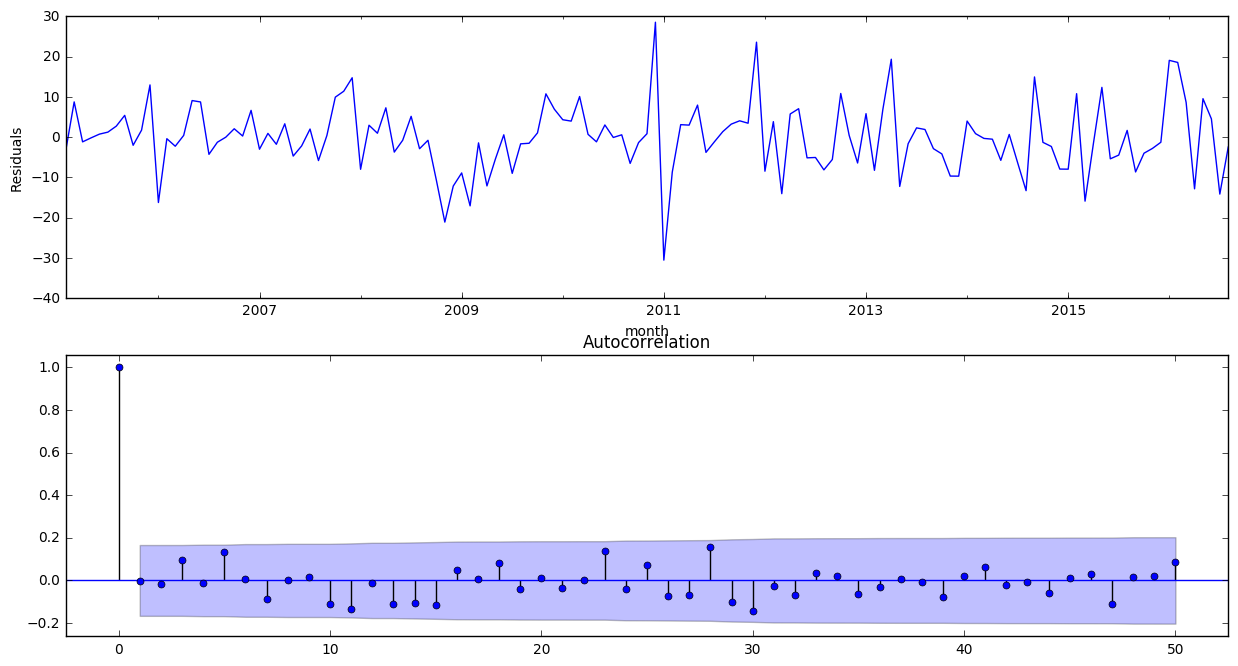

In [17]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=50, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Стьюдента меньше 1.96 -> остатки несмещены.
Критерий Дики-Фуллера мал -> остатки стационарны.
Критерий Льюнга-Бокса  = 0.61 -> остатки не автокоррелированы.

Проверим модель на исторических данных:

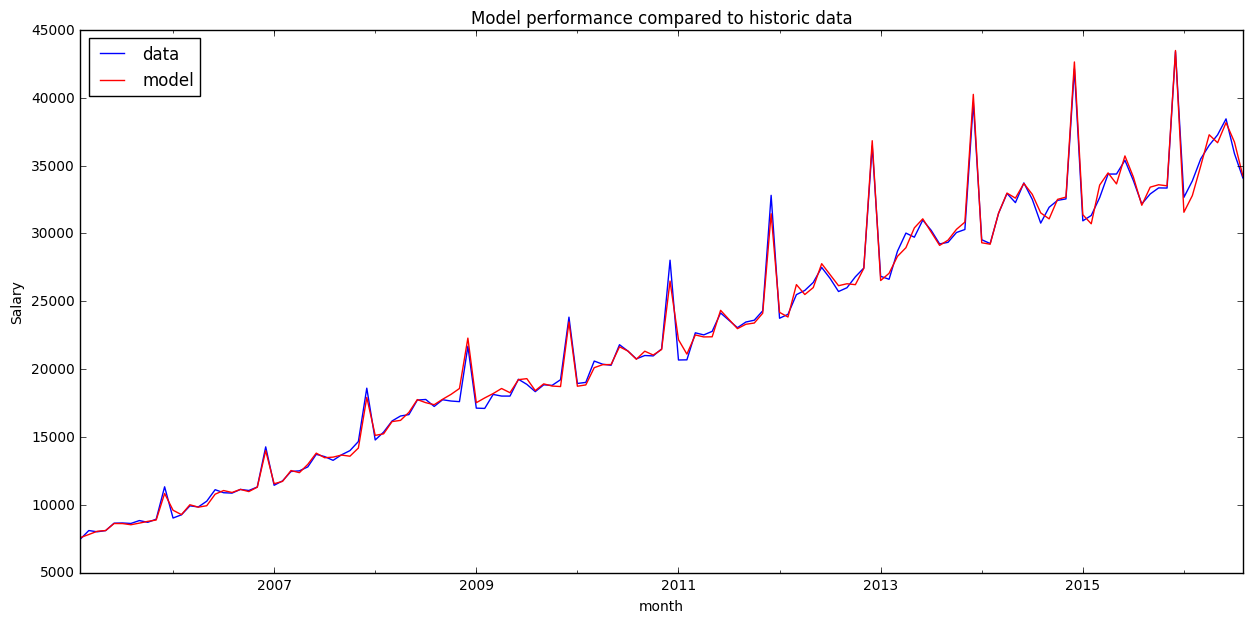

In [18]:
wages['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wages.data[13:].plot()
wages.model[13:].plot(color='r')
plt.ylabel('Salary')
plt.title('Model performance compared to historic data')
plt.legend(loc=2)
pylab.show()

### 7. Прогнозирование с помощью финальной модели.

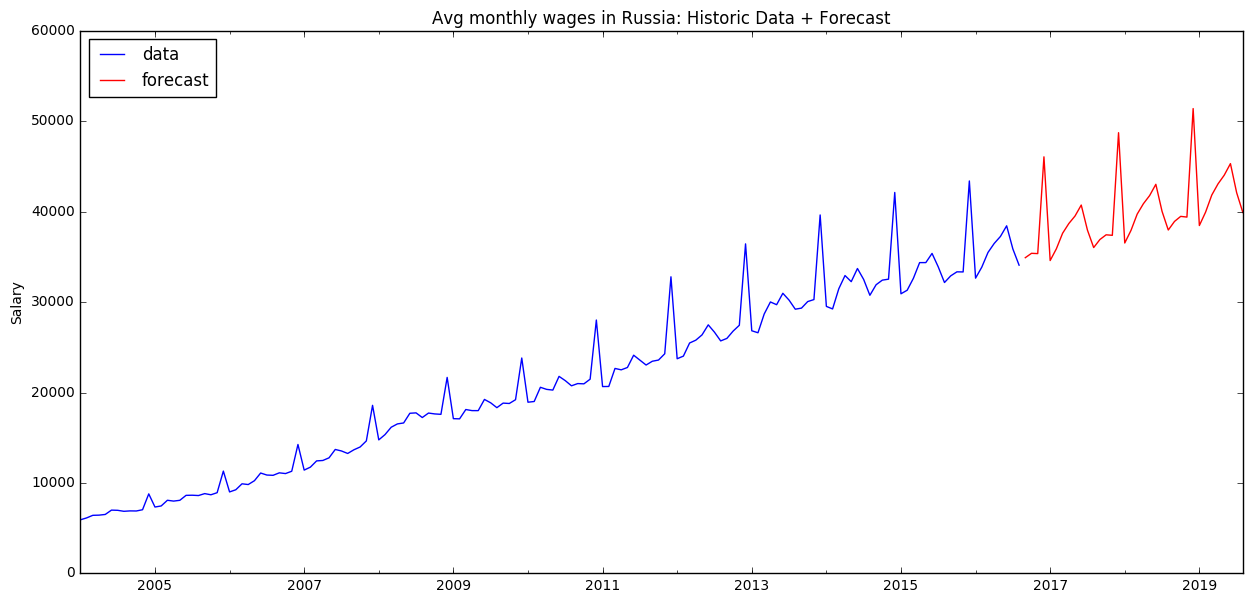

In [19]:
wages_copy = wages[['data']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=wages_copy.columns)
wages_copy = pd.concat([wages_copy, future])
wages_copy['forecast'] = invboxcox(best_model.predict(start=len(wages), end=len(wages)+len(future)-1), lmbda)

plt.figure(figsize(15,7))
wages_copy.data.plot()
wages_copy.forecast.plot(color='r')
plt.legend(loc=2)
plt.title('Avg monthly wages in Russia: Historic Data + Forecast')
plt.ylabel('Salary')
pylab.show()